# Automated feature selection with sklearn
## Discussion <br>
The optimal machine learning problem approach is to take a dataset, perform extensive EDA on it, and understand many to most of the important properties of 
the predictors before getting as far as seriously training models on these variables. However, this is not always possible. Sometimes the dataset has too 
many variables. Datasets may easily have hundreds or even thousands of variables, quickly outrunning human comprehension. Other times there just isn't 
enough time. Many machine learning -related Kaggle notebooks, for example, are based on easily processed data, or only on well-understood subsets of data. 
This is due to laziness, as there is a boundary to how many variables your average notebook author is willing to deal with, and how much time they're 
willing to dedicate to the task at hand.
<br>
Feature selection is the process of tuning down the number of predictor variables used by the models you build. For example, when faced with two models with 
the same or nearly the same score, but with the latter model using more variables, your immediate instinct should be to choose the one with fewer variables. 
That model is simpler to train, simpler to understand, easier to run, and less likely to be leaky. Tuning the number of parameters in a model is a natural 
part of data science in practice, and is something that comes naturally as part of the model-building process. While the number of features is small or you 
have time to sit down and consider them all feature selection is mainly a hand-driven process. In scenarios where the number of variables are overwhelming, 
or your time is limited, automated or semi-automated feature selection can speed things up.
<br>
And even when you do have the incentive to hand-roll and -curate your features, automated feature selection provides some useful early directions for 
exploration during the exploratory process.
<br>
In this notebook I examine and demonstrate some tools available in Python for performing automated feature selection. I find almost all the sklearn 
feature selection algorithms to be useful (if not to use, then at least to think about), so this notebook has very similar coverage to the material 
covered in the __[official documentation](https://scikit-learn.org/stable/modules/feature_selection.html)__.

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## GenericUnivariateSelect
GenericUnivariateSelect is a sklearn.feature_selection tool that allows you to select features from a dataset using a scoring function. It supports selecting columns in one of a few different configurations: k for when you want a specific number of columns, percentile for when you want to a percentage of the total number of columns, and so on.
<br>
This operator's main feature is its lack of opinion. Defining the metric is up to you; you pass it a function and it does the rest.
<br>
To demonstrate the API let's first try GenericUnivariateSelect out on a simple character recognition problem.

In [36]:
path_testImage = r"..\Tech Examples Feature Selection Algorithms\arabic_handwritten_characters\csvTestImages 3360x1024.csv".replace("\\","/")
path_trainImage = r"..\Tech Examples Feature Selection Algorithms\arabic_handwritten_characters\csvTrainImages 13440x1024.csv".replace("\\","/")
path_testLabel = r"..\Tech Examples Feature Selection Algorithms\arabic_handwritten_characters\csvTestLabel 3360x1.csv".replace("\\","/")
path_trainLabel= r"..\Tech Examples Feature Selection Algorithms\arabic_handwritten_characters\csvTrainLabel 13440x1.csv".replace("\\","/")

chars = pd.concat([pd.read_csv(path_testImage, header=None), pd.read_csv(path_trainImage, header=None)])
chars = chars.assign(label=pd.concat([pd.read_csv(path_testLabel, header=None), pd.read_csv(path_trainLabel, header=None)]).values)

chars_X = chars.iloc[:, :-1]
chars_y = chars.iloc[:, -1]

In [37]:
chars_X.shape 
# Result:
# (16800, 1024) - i.e. we have a 32 x 32 = 1024 vectorized image in each row

(16800, 1024)

This dataset consists of several thousand 32-by-32 pixel images of handwritten Arabic characters. Here's one example of a glyph from the dataset:

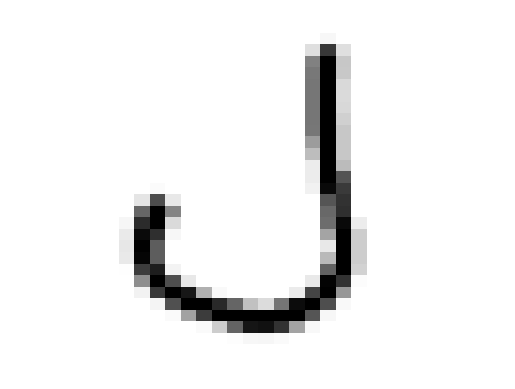

In [38]:
sns.heatmap(chars.iloc[100, :-1].values.reshape((32, 32)).T, cmap='Greys', cbar=False)
plt.axis('off')
pass

In training on this dataset it may naturally occur to us that, hey, most of the space in the image is actually whitespace: the space around the character not taken up by the character itself. Given this fact, we might decide that a worthwhile strategy would be to first preprocess the data to remove the pixel values that are mostly whitespace. Here is a heatmap demonstrating what implementing this strategy would look like:<br>

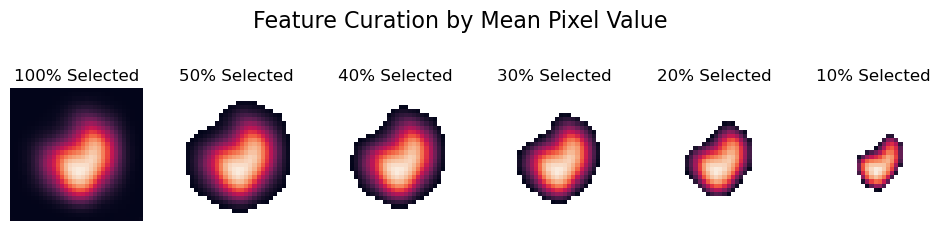

In [39]:
def sp(p, ax):
    # calculate the mean for each single pixel over all images.
    char_pixel_means = chars_X.mean(axis=0).values 

    # this is np.where with one argument only -> same as np.nonzero:
    idx_selected = np.where(char_pixel_means > np.percentile(char_pixel_means, p))[0] 

    # inverts the selected and non-selected and creates a 32 x 32 mask for use as a mask in sns.heatmap:
    arr = np.isin(np.array(list(range(32*32))), idx_selected).reshape((32, 32)).astype(int) == False 
    
    # more explanation of the code/ alternative code with the same functionality:
    #non_idx_selected = np.where(char_pixel_means <= np.percentile(char_pixel_means, p))[0] # select the indeces of the pixes not to be shown
    #arr = np.isin(np.array(list(range(32*32))), non_idx_selected).reshape((32, 32)).astype(int) # generate a 32 by 32 mask - "true", where not to be shown

    sns.heatmap(chars_X.mean(axis=0).values.reshape(32, 32), ax=ax, cbar=False, mask=arr) # show masked image of pixel-means
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title("{0}% Selected".format(100-p))

fig, axarr = plt.subplots(1, 6, figsize=(12, 3))
sns.heatmap(chars_X.mean(axis=0).values.reshape(32, 32), ax=axarr[0], cbar=False)
axarr[0].axis('off')
axarr[0].set_aspect('equal')
axarr[0].set_title("100% Selected")
plt.suptitle("Feature Curation by Mean Pixel Value", fontsize=16)

sp(50, axarr[1])
sp(60, axarr[2])
sp(70, axarr[3])
sp(80, axarr[4])
sp(90, axarr[5])

This heatmap shows the mean value of each pixel in the dataset. White-hot pixels are the ones that most often have data (a glyph passes through them), while black pixels lack any data. As we go further right we retain fewer and fewer of the original pixels.<br>

By looking at this point you might reasonably conclude that curating the feature space by 50% would be appropriate. GenericUnivariateSelect makes it easy to implement this strategy. Here's all you need to do:

In [40]:
from sklearn.feature_selection import GenericUnivariateSelect

trans = GenericUnivariateSelect(score_func=lambda X, y: X.mean(axis=0), mode='percentile', param=50)
chars_X_trans = trans.fit_transform(chars_X, chars_y)

Using this function revolves around inputting a function that takes the X and y arrays, performs some kind of statistical test on the values, and then returns the score per feature in X.

In [41]:
print("We started with {0} pixels but retained only {1} of them!".format(chars_X.shape[1], chars_X_trans.shape[1]))

We started with 1024 pixels but retained only 512 of them!


It's really useful to able to hand-roll your metrics like this. But for automated feature selection, we probably want to avoid coming up with our own expressions. Luckily sklearn defines a handful of different pre-built statistical tests that we may use. These are: <br>

- For regression: f_regression, mutual_info_regression
- For classification: chi2, f_classif, mutual_info_classif<br>

All of these tests in some way attempt to infer the "relatedness" of the predictor variables with the target variables. There are two classes of these tests, one implemented for regression and the other implemented for classification.<br>

I prefer the mutual_info_* tests because they "just work" out of the box. These are non-parametric tests which use k-nearest neighbors to measure the scale of the relationship between the predictor values and the target variable. The F-test statistics only find linear relationships, making them only appropriate for performing linear regression, and the chi-squared test requires that the data be appropriately scaled (which it rarely is) and non-negative (which it only sometimes is).<br>

To demonstrate, I'll use the Kepler dataset. This dataset contains information on potential planets observed and confirmed or unconfirmed by the Kepler Space Observatory.<br>

In [42]:
pd.set_option('display.max_columns', None)
pathKepler = r"..\Tech Examples Feature Selection Algorithms\kepler_cumulative.csv".replace("\\","/")
kepler = pd.read_csv(pathKepler)
kepler = (kepler
     .drop(['rowid', 'kepid'], axis='columns')
     .rename(columns={'koi_disposition': 'disposition', 'koi_pdisposition': 'predisposition'})
     .pipe(lambda df: df.assign(disposition=(df.disposition == 'CONFIRMED').astype(int), predisposition=(df.predisposition == 'CANDIDATE').astype(int)))
     .pipe(lambda df: df.loc[:, df.dtypes.values != np.dtype('O')])  # drop str columns
     .pipe(lambda df: df.loc[:, (df.isnull().sum(axis='rows') < 500).where(lambda v: v).dropna().index.values])  # drop columns with greater than 500 null values
     .dropna()
)

kepler_X = kepler.iloc[:, 1:]
kepler_y = kepler.iloc[:, 0]

kepler.head()

,disposition,predisposition,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,koi_impact,koi_impact_err1,koi_impact_err2,koi_duration,koi_duration_err1,koi_duration_err2,koi_depth,koi_depth_err1,koi_depth_err2,koi_prad,koi_prad_err1,koi_prad_err2,koi_teq,koi_insol,koi_insol_err1,koi_insol_err2,koi_model_snr,koi_tce_plnt_num,koi_steff,koi_steff_err1,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,1,1,0,0,0,0,9.488036,2.775000e-05,-2.775000e-05,170.538750,0.002160,-0.002160,0.146,0.318,-0.146,2.95750,0.08190,-0.08190,615.8,19.5,-19.5,2.26,0.26,-0.15,793.0,93.59,29.45,-16.65,35.8,1.0,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,1,1,0,0,0,0,54.418383,2.479000e-04,-2.479000e-04,162.513840,0.003520,-0.003520,0.586,0.059,-0.443,4.50700,0.11600,-0.11600,874.8,35.5,-35.5,2.83,0.32,-0.19,443.0,9.11,2.87,-1.62,25.8,2.0,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,0,0,0,1,0,0,19.899140,1.494000e-05,-1.494000e-05,175.850252,0.000581,-0.000581,0.969,5.126,-0.077,1.78220,0.03410,-0.03410,10829.0,171.0,-171.0,14.60,3.92,-1.31,638.0,39.30,31.04,-10.49,76.3,1.0,5853.0,158.0,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,0,0,0,1,0,0,1.736952,2.630000e-07,-2.630000e-07,170.307565,0.000115,-0.000115,1.276,0.115,-0.092,2.40641,0.00537,-0.00537,8079.2,12.8,-12.8,33.46,8.50,-2.83,1395.0,891.96,668.95,-230.35,505.6,1.0,5805.0,157.0,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,1,1,0,0,0,0,2.525592,3.761000e-06,-3.761000e-06,171.595550,0.001130,-0.001130,0.701,0.235,-0.478,1.65450,0.04200,-0.04200,603.3,16.9,-16.9,2.75,0.88,-0.35,1406.0,926.16,874.33,-314.24,40.9,1.0,6031.0,169.0,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509


We can apply mutual_info_classif by running a simple built-in. Here I've plotted out the resulting per-variable score in a heatmap.

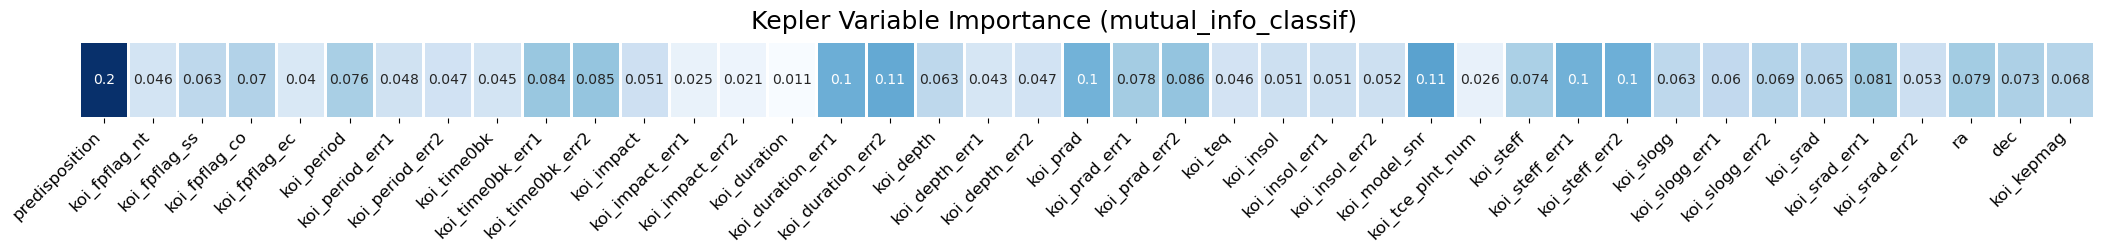

In [15]:
from sklearn.feature_selection import mutual_info_classif
kepler_mutual_information = mutual_info_classif(kepler_X, kepler_y)

plt.subplots(1, figsize=(26, 1))
sns.heatmap(kepler_mutual_information[:, np.newaxis].T, cmap='Blues', cbar=False, linewidths=1, annot=True)
plt.yticks([], [])
plt.gca().set_xticklabels(kepler.columns[1:], rotation=45, ha='right', fontsize=12)
plt.suptitle("Kepler Variable Importance (mutual_info_classif)", fontsize=18, y=1.2)
plt.gcf().subplots_adjust(wspace=0.2)
pass

Unsurprisingly the variable that best predicts whether or not Kepler will classify an object as a planet or not is the predisposition—that is, whether or not the planet is already considered a CANDIDATE or not (usually the alternative is FALSE POSITIVE, and Kepler is just double-checking).<br>

Suppose we want to work with just the top fifty percent of the columns here. Then we would do:

In [16]:
trans = GenericUnivariateSelect(score_func=mutual_info_classif, mode='percentile', param=50)
kepler_X_trans = trans.fit_transform(kepler_X, kepler_y)
print("We started with {0} features but retained only {1} of them!".format(kepler_X.shape[1] - 1, kepler_X_trans.shape[1]))

We started with 40 features but retained only 20 of them!


So far we've been using GenericUnivariateSelect with percentile arguments, however the available selection options are actually {‘percentile’, ‘k_best’, ‘fpr’, ‘fdr’, ‘fwe’}. The second of these is obviously "give me the N best features", but the remaining three options take a bit of explaining. All three of them are statistical significance tests, e.g. they are designed to select all columns which pass a certain p-value threshold. fpr is the false positive rate: we may use this argument to select columns with a certain level of risk (e.g. 25%) that they not correlated after all. fdr is the false discovery rate, and can be specified to select columns with a certain level of risk that actually correlated columns will be rejected. Finally, fwe is family-wide error rate; this can be used to control the level of risk that at least one of the columns returned is not actually correlated.<br>

That's a lot of statistical trickery. Up to you whether or not you're comfortable using this toolchain.<br>

Here are the columns that we selected:<br>

In [17]:
columns_retained_Select = kepler.iloc[:, 1:].columns[trans.get_support()].values
pd.DataFrame(kepler_X_trans, columns=columns_retained_Select).head()

,predisposition,koi_fpflag_ss,koi_period,koi_time0bk_err1,koi_time0bk_err2,koi_duration_err1,koi_duration_err2,koi_prad,koi_prad_err1,koi_prad_err2,koi_model_snr,koi_steff,koi_steff_err1,koi_steff_err2,koi_slogg_err2,koi_srad,koi_srad_err1,ra,dec,koi_kepmag
0,1.0,0.0,9.488036,0.002160,-0.002160,0.08190,-0.08190,2.26,0.26,-0.15,35.8,5455.0,81.0,-81.0,-0.096,0.927,0.105,291.93423,48.141651,15.347
1,1.0,0.0,54.418383,0.003520,-0.003520,0.11600,-0.11600,2.83,0.32,-0.19,25.8,5455.0,81.0,-81.0,-0.096,0.927,0.105,291.93423,48.141651,15.347
2,0.0,1.0,19.899140,0.000581,-0.000581,0.03410,-0.03410,14.60,3.92,-1.31,76.3,5853.0,158.0,-176.0,-0.176,0.868,0.233,297.00482,48.134129,15.436
3,0.0,1.0,1.736952,0.000115,-0.000115,0.00537,-0.00537,33.46,8.50,-2.83,505.6,5805.0,157.0,-174.0,-0.168,0.791,0.201,285.53461,48.285210,15.597
4,1.0,0.0,2.525592,0.001130,-0.001130,0.04200,-0.04200,2.75,0.88,-0.35,40.9,6031.0,169.0,-211.0,-0.210,1.046,0.334,288.75488,48.226200,15.509


Note the use of the get_support() method on the GenericUnivariateSelect object to get the indices of the columns that were carried over.<br>

For the official documentation on GenericUnivariateSelect click __[here](https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection)__.

## Model-based feature selection (SelectFromModel)
Some machine learning algorithms naturally assign importance to dataset features in some way. The obvious example is linear regression, which works by applying a coefficient multiplier to each of the features. Obviously, the higher the coefficient, the more valuable the feature. Other good examples are lasso regression, which features built-in variable selection (I show an application of this feature here) by taking the coef_ of features deemed insignificant to 0, and decision trees, which feature expose Gini importance via a feature_importances_ class variable.<br>

We can perform feature selection by using the feature ranks generated by such machine learning models as a ranking, and then pruning the features based on that ranking. This approach is good because it is non-parametric; basing our selection on features that get picked by an actual machine learning algorithm, not a statistical test, makes a lot of sense. Of course, in this case the choice of the algorithm you use matters a lot. The sklearn documentation describing this approach (here) points out the best options for this approach: linear_model.Lasso or trees.DecisionTreeRegressor for regression, and one of linear_model.LogisticRegression and svm.LinearSVC and trees.DecisionTreeClassifier for classification.<br>

If your goal is to build a logistic model or a linear support vector machine then it makes sense to make your feature selection decisions based on outputs from those two models, but in general decision trees are by far the most popular choice for model-based feature selection. This is because they provide an easily interpretable measurement, Gini efficiency, and have been found to work great at ranking feature importance in practice.<br>

Measuring feature importance this way is simple:<br>

<AxesSubplot:>

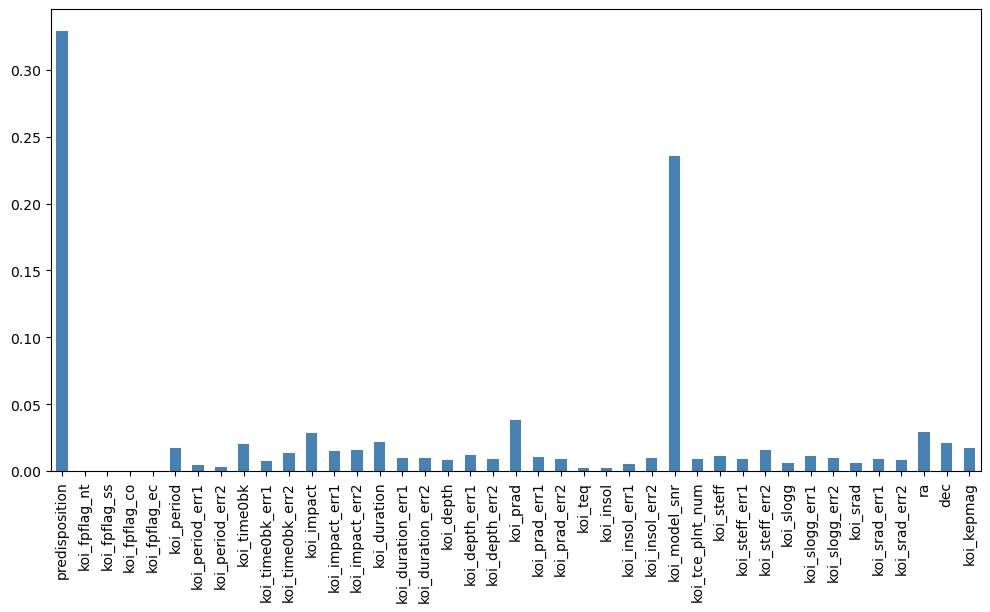

In [18]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
clf.fit(kepler_X, kepler_y)

pd.Series(clf.feature_importances_, index=kepler.columns[1:]).plot.bar(color='steelblue', figsize=(12, 6))

These results agree decently well with the results we got from the information-theoretic approach in the previous section. Note: I demonstrated how to build this exact feature importance chart in even fewer steps using the yellowbricks ML visualization library in [this previous notebook](https://www.kaggle.com/code/residentmario/ml-visualization-with-yellowbrick-1/notebook).<br>

sklearn comes with a simple wrapper for turning these feature importance scores into a feature subselection called SelectFromModel. With that function in tow, here is the entire process:<br>

In [22]:
from sklearn.feature_selection import SelectFromModel

clf = DecisionTreeClassifier()
trans = SelectFromModel(clf, threshold='median')
kepler_X_trans = trans.fit_transform(kepler_X, kepler_y)
print("We started with {0} features but retained only {1} of them!".format(kepler_X.shape[1] - 1, kepler_X_trans.shape[1]))

columns_retained_FromMode = kepler.iloc[:, 1:].columns[trans.get_support()].values
columns_retained_FromMode

We started with 40 features but retained only 21 of them!


array(['predisposition', 'koi_period', 'koi_time0bk', 'koi_time0bk_err1',
       'koi_impact', 'koi_impact_err1', 'koi_impact_err2', 'koi_duration',
       'koi_duration_err1', 'koi_depth', 'koi_depth_err1',
       'koi_depth_err2', 'koi_prad', 'koi_prad_err1', 'koi_model_snr',
       'koi_steff_err1', 'koi_steff_err2', 'koi_slogg_err1', 'ra', 'dec',
       'koi_kepmag'], dtype=object)

## Recursive feature elimination (RFE and RFECV)
Recursive feature elimination is the sklearn sort-of implementation of a really old idea (stepwise selection) that used to be very popular. Given a set of data, build a model on that data, then assess the importance of the variables and prune the weakest feature. Rebuild the classifier (especially in later steps, the coefficient coverage will change), then repeat the process. Keep doing this until the desired number of features is reached.<br>

This methodology is implemented in RFE, and is basically just a looped alternative to the SelectFromModel all-at-once approach. The advantage of this approach is that it will not remove variables which were deemed insignificant at the beginning of the process, but become more and more significant as lesser features are removed. For datasets with many variables relatively strongly correlated with one another and relatively weakly correlated with the target variable, this approach may result in slightly different feature choices from those made by naive model-based selection. The disadvantage is that since you have to train the model many times, this approach is multiplicatively slower than the one-and-done.

In [24]:
from sklearn.feature_selection import RFE

clf = DecisionTreeClassifier()
trans = RFE(clf, n_features_to_select=20)
kepler_X_trans = trans.fit_transform(kepler_X, kepler_y)
columns_retained_RFE = kepler.iloc[:, 1:].columns[trans.get_support()].values
columns_retained_RFE

array(['predisposition', 'koi_time0bk', 'koi_time0bk_err2', 'koi_impact',
       'koi_impact_err2', 'koi_duration', 'koi_duration_err2',
       'koi_depth_err2', 'koi_prad', 'koi_prad_err2', 'koi_insol_err2',
       'koi_model_snr', 'koi_steff', 'koi_steff_err1', 'koi_steff_err2',
       'koi_srad_err1', 'koi_srad_err2', 'ra', 'dec', 'koi_kepmag'],
      dtype=object)

RFECV is a slight tweak to RFE that uses cross-validation to determine the optimal stopping point in terms of numbers of columns (eliminating user choice in the n_features_to_select attribute).

In [25]:
from sklearn.feature_selection import RFECV

clf = DecisionTreeClassifier()
trans = RFECV(clf)
kepler_X_trans = trans.fit_transform(kepler_X, kepler_y)
columns_retained_RFECV = kepler.iloc[:, 1:].columns[trans.get_support()].values

It appears that I accidentally chose a good number of predictor variables, at least as far as RFECV is concerned:

In [ ]:
len(columns_retained_RFECV)

While I won't spend any more time treating RFECV here, you can read a bit more on cross-validation and get some insight into how this algorithm works by looking at this [notebook](https://www.kaggle.com/code/residentmario/cross-validation-schemes-with-food-consumption/notebook).

## Conclusion
Although the different approaches agree on the most important variables in the dataset, they disagree on the finer points. This results in sometimes different, sometimes very different column selections, depending on the algorithm. The following list considers the 3! possible pairs of feature choices, and the difference in the sets chosen by the selectors for the Kepler dataset:

[ I don not understand what he means with "3! possible pairs of feature Choices" - why only pairs of features?]

In [26]:
import itertools
pairs = {}
for (i, (a, b)) in enumerate(itertools.combinations([set(columns_retained_Select), set(columns_retained_FromMode), set(columns_retained_RFE), set(columns_retained_RFECV)], 2)):
    pairs.update({str(i): len(a.difference(b))})
    
print("Enumerating differences between  3!")
list(pairs.values())

Enumerating differences between  3!


[8, 7, 13, 8, 10, 10]

That these different approaches came to such deviant conclusions is not unexpected; it's mainly a signal that the weaker of the 20 features we've selected mostly come down to noise, as all of the feature importance and ranking visualizations we have constructed so far have shown.

That concludes this notebook! In the next notebook I will step beyond sklearn built-in to consider a feature selection algorithm implemented as an sklearn-contrib module: boruta.

See that notebook here.

PS: you may also like this thread on the [Kaggle Q&A](https://www.kaggle.com/questions-and-answers/46335) Forum.

## Other Feature Selection Algorithms from Sklearn
VarianceThreshold is a simple baseline approach to feature selection. It removes all features whose variance doesn’t meet some threshold. By default, it removes all zero-variance features, i.e. features that have the same value in all samples.<br>

As an example, suppose that we have a dataset with boolean features, and we want to remove all features that are either one or zero (on or off) in more than 80% of the samples. Boolean features are Bernoulli random variables, and the variance of such variables is given by<br>

$Var[X]= p(1-p)$

so we can select using the threshold .8 * (1 - .8):

In [27]:
from sklearn.feature_selection import VarianceThreshold
X = [[0, 0, 1], [0, 1, 0], [1, 0, 0], [0, 1, 1], [0, 1, 0], [0, 1, 1]]
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
sel.fit_transform(X)
# expected output:
# array([[0, 1],
#       [1, 0],
#       [0, 0],
#       [1, 1],
#       [1, 0],
#       [1, 1]])

array([[0, 1],
       [1, 0],
       [0, 0],
       [1, 1],
       [1, 0],
       [1, 1]])

As expected, VarianceThreshold has removed the first column, which has a probability $p = 5/6 > 0.8$ of containing a zero and thus a Variance of <br>
$Var[X] = 5/6 * 1/6 = 5/36 = 500/3600 < 8/10 * 2/10 = 16/100 = 576/3600$


In [28]:
16 * 36

576